### Demo of using HMMS for sequence classification

    1. Create two Hidden Markov Models
    2. Generate sample sequences from each model.
    3. Split these test sequences into train/test partitions
    4. Train a Classifer containing an HMM for each label
        a. Train 10 models of each label, selecting the model with the lowest LogLikelihood
    
    5. Predict labels using Maximum Likelihood (ignoring class priors)
    6. Predict labels using Maximum A Posteriori
    7. Predict Labels using MLE, but using the original generating HMMS

In [1]:
import sys

In [2]:
sys.path.insert(0, "..")

In [3]:
from hmm import CategoricalHMM, HMMSearch, HMMClassifier, distance, plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.metrics

In [4]:
%matplotlib inline

### Two separate HMM definitions

Different initializations for pi and A, but B is the same

In [5]:
pi_1 = [ .5, .3, .2]
A_1 = [ [0.6, 0.3, 0.1], 
       [0.4, 0.4, 0.2],
       [0.1, 0.3, 0.6]
      ]
B_1 = [
    [0.5, 0.4, 0.1],
    [0.1, 0.3, 0.6],
    [0.6, 0.2, 0.2]
]

pi_2 = [ .4, .6]
A_2 = [ [0.8, 0.2], [0.6, 0.4]]
B_2 = [
    [0.2, 0.3, 0.5],
    [0.3, 0.3, 0.3]
]


### Generate sample data

In [6]:
hmm1 = CategoricalHMM.CategoricalHMM(
    n_iterations=0,
    init_pi=None,
    init_emissions=None,
    init_A=None,
)
hmm1.pi_ = pi_1
hmm1.A_ = A_1
hmm1.B_ = B_1

In [7]:
print(hmm1.pi_)
print(hmm1.A_)
print(hmm1.B_)

[0.5, 0.3, 0.2]
[[0.6, 0.3, 0.1], [0.4, 0.4, 0.2], [0.1, 0.3, 0.6]]
[[0.5, 0.4, 0.1], [0.1, 0.3, 0.6], [0.6, 0.2, 0.2]]


In [8]:
hmm2 = CategoricalHMM.CategoricalHMM(
    n_iterations=0,
    init_pi=None,
    init_emissions=None,
    init_A=None,
)
hmm2.pi_ = pi_2
hmm2.A_ = A_2
hmm2.B_ = B_2

In [9]:
print(hmm2.pi_)
print(hmm2.A_)
print(hmm2.B_)

[0.4, 0.6]
[[0.8, 0.2], [0.6, 0.4]]
[[0.2, 0.3, 0.5], [0.3, 0.3, 0.3]]


### Train on an imbalanced dataset

In [10]:
a_observations, a_hiddens = hmm1.sample(n_samples=200, length=50)
b_observations, b_hiddens = hmm2.sample(n_samples=100, length=50)

Verifying that matrices were normalied

In [11]:
print(hmm2.pi_)
print(hmm2.A_)
print(hmm2.B_)

[0.4 0.6]
[[0.8 0.2]
 [0.6 0.4]]
[[0.2        0.3        0.5       ]
 [0.33333333 0.33333333 0.33333333]]


In [12]:
a_train_observations, a_test_observations = sklearn.model_selection.train_test_split(a_observations)
b_train_observations, b_test_observations = sklearn.model_selection.train_test_split(b_observations)

X_train = np.concatenate([a_train_observations, b_train_observations])
y_train = np.asarray(["class-a"] * len(a_train_observations) + ["class-b"] * len(b_train_observations))
X_test = np.concatenate([a_test_observations, b_test_observations])
y_test = np.asarray(["class-a"] * len(a_test_observations) + ["class-b"] * len(b_test_observations))


In [13]:
pd.Series(y_train).value_counts()

class-a    150
class-b     75
dtype: int64

### Train the classifier 
I don't quite have it working to select an optimal number of states. In the literature AIC, BIC, Cross Validation are all mentioned as options, with conflicting advice.  The marketing literature also measures how well the hidden states are separated from each other, and there is interesting work done in the biological world, especially with regards to animal tracking.  Also can look at the how things are done in the Protien/dna sequencing field

 * https://core.ac.uk/download/pdf/82597511.pdf (Analysis of Genome Data)
 * https://arxiv.org/abs/1701.08673 (HMM Selection with Animal tracking applications)
 * http://etd.fcla.edu/UF/UFE0041157/zhang_x.pdf (Doctoral Thesis - yikes)
 * http://www.columbia.edu/~on2110/Papers/Ebbes_Netzer_2018.pdf (marketing science)

Instead, we'll fix the number of states, and train 10 models for each state, keeping the model that best approximates the generated data.

In [14]:
a_new = CategoricalHMM.CategoricalHMM(
    n_components=3,
    n_inits=4,
    n_iterations=1000,
    n_jobs=4,
    
    random_state=sklearn.utils.check_random_state(23),
)

b_new = CategoricalHMM.CategoricalHMM(
    n_components=2,
    n_inits=4,
    n_iterations=1000,
    n_jobs=4,    
    )

# Classifier with models learned from the data
classifier_mle = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="mle",
)

classifier_map = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="map",
)

# Classifer using the models that generated the data
original = HMMClassifier.HMMClassifier(
    {
        "class-a": hmm1,
        "class-b": hmm2,
    },
    predict_method="mle"
)

In [15]:
%time classifier_mle.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


CPU times: user 31.5 ms, sys: 20.9 ms, total: 52.4 ms
Wall time: 11.7 s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=3, n_features=None, n_inits=4, n_iterations=1000,
        n_jobs=4,
        random_state=<mtrand.RandomState object at 0x5...ts=4, n_iterations=1000,
        n_jobs=4, random_state=None, smoothing=None, tol=1e-06, verbose=0)},
       predict_method='mle')

In [16]:
%time classifier_map.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


CPU times: user 17.8 ms, sys: 393 µs, total: 18.2 ms
Wall time: 7.39 s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=3, n_features=None, n_inits=4, n_iterations=1000,
        n_jobs=4,
        random_state=<mtrand.RandomState object at 0x5...ts=4, n_iterations=1000,
        n_jobs=4, random_state=None, smoothing=None, tol=1e-06, verbose=0)},
       predict_method='map')

### Internal States of learned models

In [17]:
print("pi")
print(classifier_mle.trained_models_["class-a"].pi_)
print("A")
print(classifier_mle.trained_models_["class-a"].A_)
print("B")
print(classifier_mle.trained_models_["class-a"].B_)


pi
[0.42945766 0.40923625 0.16130609]
A
[[0.46106641 0.18963532 0.34929827]
 [0.3261757  0.53923861 0.13458569]
 [0.31682028 0.15043748 0.53274225]]
B
[[0.6043489  0.24062496 0.15502614]
 [0.19596133 0.51368733 0.29035134]
 [0.33817592 0.22636825 0.43545583]]


In [18]:
print("pi")
print(classifier_mle.trained_models_["class-b"].pi_)
print("A")
print(classifier_mle.trained_models_["class-b"].A_)
print("B")
print(classifier_mle.trained_models_["class-b"].B_)


pi
[0.00409399 0.99590601]
A
[[0.38901096 0.61098904]
 [0.63625164 0.36374836]]
B
[[0.20331895 0.30721296 0.48946809]
 [0.3064199  0.29861991 0.39496019]]


### MLE Models


Trained class-a models


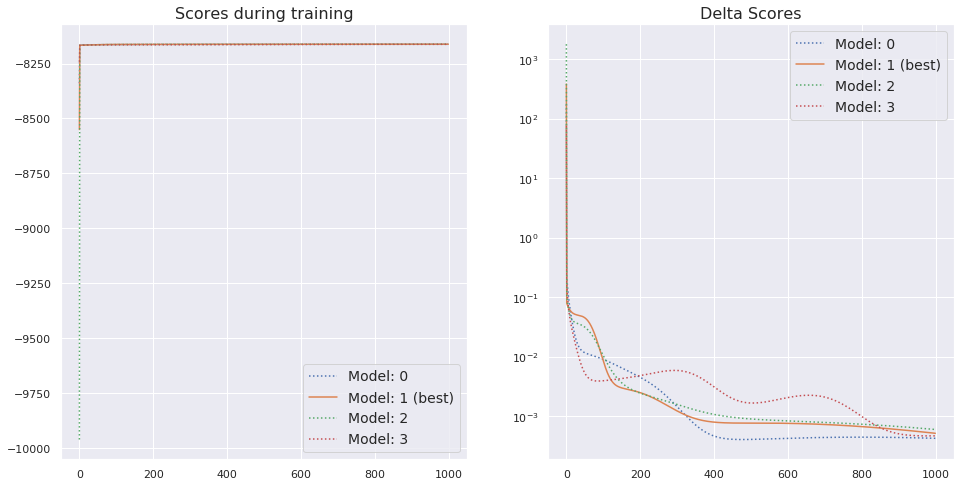

In [19]:
print("Trained class-a models")
_ = plots.multiple_learning_plot(classifier_mle.trained_models_["class-a"].explored_loglikelihoods_)

Trained class-b models


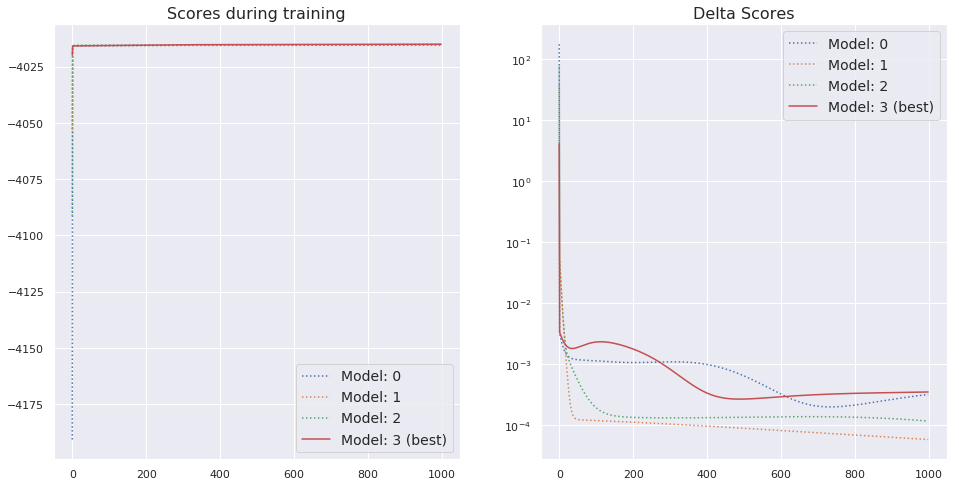

In [20]:
print("Trained class-b models")
_ = plots.multiple_learning_plot(classifier_mle.trained_models_["class-b"].explored_loglikelihoods_)    

### MAP Models

Trained class-a models


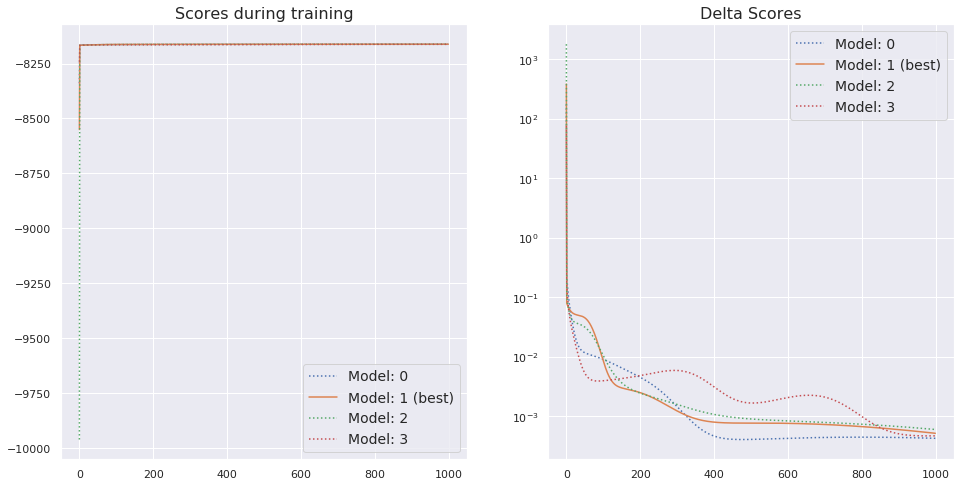

In [21]:
print("Trained class-a models")
_ = plots.multiple_learning_plot(classifier_map.trained_models_["class-a"].explored_loglikelihoods_)    


Trained class-b models


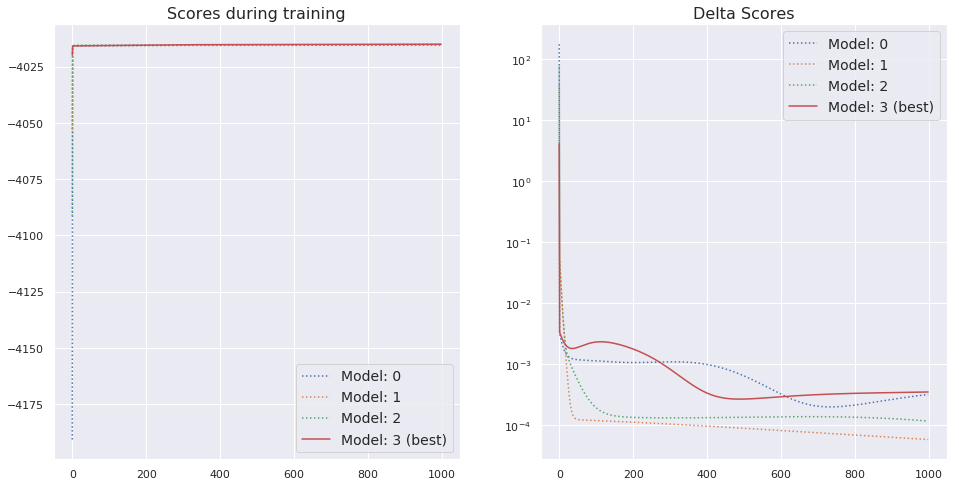

In [22]:
print("Trained class-b models")
_ = plots.multiple_learning_plot(classifier_map.trained_models_["class-b"].explored_loglikelihoods_)    


Models above are identical in resulting LLs, but this is because they all grab the random state and go to a 
thread, so they all end up with identical initializations

#### Build the model based on the original distributions
Not really "fitting" the model, as we intialized it with zero iterations.

In [23]:
%time original.fit(X_train, y_train)

CPU times: user 2.38 ms, sys: 0 ns, total: 2.38 ms
Wall time: 2.39 ms


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': CategoricalHMM(allowed_to_use_log=True, implementation='scaling', init_A=None,
        init_emissions=None, init_pi=None, n_components=3, n_features=None,
        n_inits=1, n_iterations=0, n_jobs=-1, random_state=None,
        smoothing=None, tol=1e-06, verbose=0), 'class-b':...nits=1, n_iterations=0, n_jobs=-1, random_state=None,
        smoothing=None, tol=1e-06, verbose=0)},
       predict_method='mle')

In [24]:
y_test_proba_mle = classifier_mle.predict_proba(X_test)
y_test_proba_map = classifier_map.predict_proba(X_test)
y_origin_test_proba_mle = original.predict_proba(X_test)

### Examine Predictions


In [25]:
pd.DataFrame(y_test_proba_mle, columns=["class-a", "class-b"])

class-a   class-b
0   0.978932  0.021068
1   0.141467  0.858533
2   0.041541  0.958459
3   0.972172  0.027828
4   0.999399  0.000601
5   0.965837  0.034163
6   0.742261  0.257739
7   0.988908  0.011092
8   0.866821  0.133179
9   0.930383  0.069617
10  0.987805  0.012195
11  0.955583  0.044417
12  0.996597  0.003403
13  0.964213  0.035787
14  0.983925  0.016075
15  0.234582  0.765418
16  0.015396  0.984604
17  0.998203  0.001797
18  0.980971  0.019029
19  0.986410  0.013590
20  0.919095  0.080905
21  0.999723  0.000277
22  0.999291  0.000709
23  0.819961  0.180039
24  0.865546  0.134454
25  0.998667  0.001333
26  0.171458  0.828542
27  0.621936  0.378064
28  0.976350  0.023650
29  0.745695  0.254305
..       ...       ...
45  0.996264  0.003736
46  0.855539  0.144461
47  0.263065  0.736935
48  0.092969  0.907031
49  0.954848  0.045152
50  0.016508  0.983492
51  0.003304  0.996696
52  0.022128  0.977872
53  0.002796  0.997204
54  0.174681  0.825319
55  0.031417  0.968583
56  0.001660  0.998340
57  0.006630  0.993370
58  0.515852  0.484148
59  0.043723  0.956277
60  0.138959  0.861041
61  0.005365  0.994635
62  0.019931  0.980069
63  0.015714  0.984286
64  0.238008  0.761992
65  0.301580  0.698420
66  0.408522  0.591478
67  0.035876  0.964124
68  0.017635  0.982365
69  0.022670  0.977330
70  0.100011  0.899989
71  0.072626  0.927374
72  0.001856  0.998144
73  0.100775  0.899225
74  0.016838  0.983162

[75 rows x 2 columns]

In [26]:
pd.DataFrame(y_test_proba_map, columns=["class-a", "class-b"])

class-a   class-b
0   0.989354  0.010646
1   0.247869  0.752131
2   0.079768  0.920232
3   0.985890  0.014110
4   0.999700  0.000300
5   0.982622  0.017378
6   0.852067  0.147933
7   0.994423  0.005577
8   0.928660  0.071340
9   0.963936  0.036064
10  0.993865  0.006135
11  0.977287  0.022713
12  0.998295  0.001705
13  0.981781  0.018219
14  0.991897  0.008103
15  0.380019  0.619981
16  0.030325  0.969675
17  0.999100  0.000900
18  0.990394  0.009606
19  0.993158  0.006842
20  0.957842  0.042158
21  0.999861  0.000139
22  0.999645  0.000355
23  0.901076  0.098924
24  0.927928  0.072072
25  0.999333  0.000667
26  0.292726  0.707274
27  0.766906  0.233094
28  0.988033  0.011967
29  0.854324  0.145676
..       ...       ...
45  0.998128  0.001872
46  0.922146  0.077854
47  0.416550  0.583450
48  0.170122  0.829878
49  0.976903  0.023097
50  0.032480  0.967520
51  0.006587  0.993413
52  0.043297  0.956703
53  0.005577  0.994423
54  0.297410  0.702590
55  0.060919  0.939081
56  0.003315  0.996685
57  0.013173  0.986827
58  0.680610  0.319390
59  0.083783  0.916217
60  0.244011  0.755989
61  0.010673  0.989327
62  0.039083  0.960917
63  0.030941  0.969059
64  0.384501  0.615499
65  0.463407  0.536593
66  0.580072  0.419928
67  0.069266  0.930734
68  0.034658  0.965342
69  0.044335  0.955665
70  0.181837  0.818163
71  0.135418  0.864582
72  0.003704  0.996296
73  0.183099  0.816901
74  0.033118  0.966882

[75 rows x 2 columns]

In [27]:
pd.Series(np.exp(classifier_map.class_log_prior_), ["class-a", "class-b"])

class-a    0.666667
class-b    0.333333
dtype: float64

### ROC
All models do well as the generating process is well separated

In [28]:
print("Original HMM AUC")
print(sklearn.metrics.roc_auc_score(y_test, y_origin_test_proba_mle[:, 1]))
print("Learned HMM AUC: MLE")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_mle[:, 1]))
print("Learned HMM AUC: MAP")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_map[:, 1]))

Original HMM AUC
0.9496000000000001
Learned HMM AUC: MLE
0.9496
Learned HMM AUC: MAP
0.9496


Text(0.5,1,'ROC - Classification example')

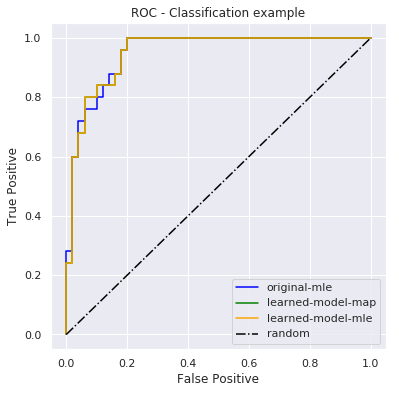

In [29]:
f, ax = plt.subplots(figsize=(6,6))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_origin_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="original-mle", color="blue")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_map[:, 1])
ax.plot(fpr, tpr, label="learned-model-map", color="green")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="learned-model-mle", color="orange")
ax.plot(np.arange(0, 1.01, .1),np.arange(0, 1.01, .1), label="random", color="black", linestyle="-.")
ax.legend()
ax.set_ylabel("True Positive")
ax.set_xlabel("False Positive")
ax.set_title("ROC - Classification example")


In [30]:
predicted_y_mle = classifier_mle.predict(X_test)
predicted_y_map = classifier_map.predict(X_test)
predicted_y_orig_mle = original.predict(X_test)

### Standard Classification Metrics

The MLE and MAP models trade off precision and recall between classes.

In [31]:
print(sklearn.metrics.classification_report(y_test, predicted_y_mle))

              precision    recall  f1-score   support

     class-a       0.98      0.80      0.88        50
     class-b       0.71      0.96      0.81        25

   micro avg       0.85      0.85      0.85        75
   macro avg       0.84      0.88      0.85        75
weighted avg       0.89      0.85      0.86        75



In [32]:
print(sklearn.metrics.classification_report(y_test, predicted_y_map))

              precision    recall  f1-score   support

     class-a       0.95      0.82      0.88        50
     class-b       0.72      0.92      0.81        25

   micro avg       0.85      0.85      0.85        75
   macro avg       0.84      0.87      0.84        75
weighted avg       0.88      0.85      0.86        75



In [33]:
print(sklearn.metrics.classification_report(y_test, predicted_y_orig_mle))

              precision    recall  f1-score   support

     class-a       0.98      0.82      0.89        50
     class-b       0.73      0.96      0.83        25

   micro avg       0.87      0.87      0.87        75
   macro avg       0.85      0.89      0.86        75
weighted avg       0.89      0.87      0.87        75



### Learned Classifier: Model Distance

In [34]:
classifier_mle.estimators["class-a"]

CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=3, n_features=None, n_inits=4, n_iterations=1000,
        n_jobs=4,
        random_state=<mtrand.RandomState object at 0x563d3e718ae8>,
        smoothing=None, tol=1e-06, verbose=0)

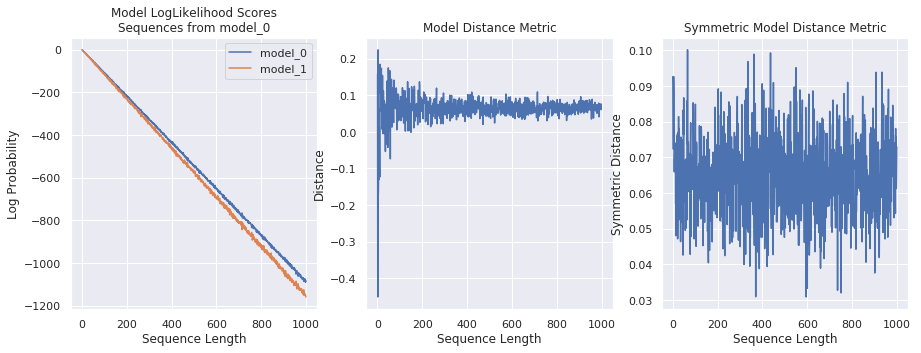

In [35]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-a"], 
    classifier_mle.estimators["class-b"]
)

### Source: Model Distance

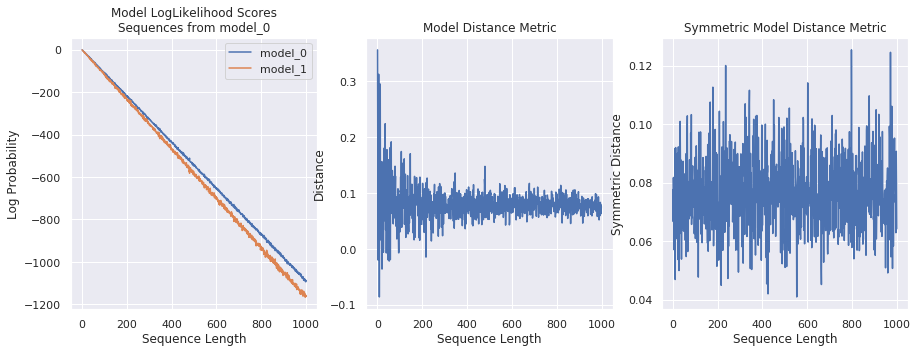

In [36]:
_ = distance.run_model_distance_tests(
    original.estimators["class-a"], 
    original.estimators["class-b"]
)

### Distance: Learned Model for class-a, Original model for class-a

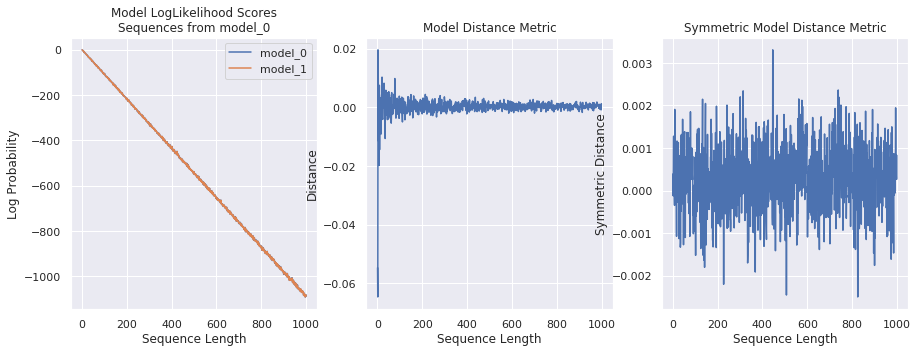

In [37]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-a"],
    original.estimators["class-a"]
)

### Distance: Learned Model for class-b, Original model for class-b

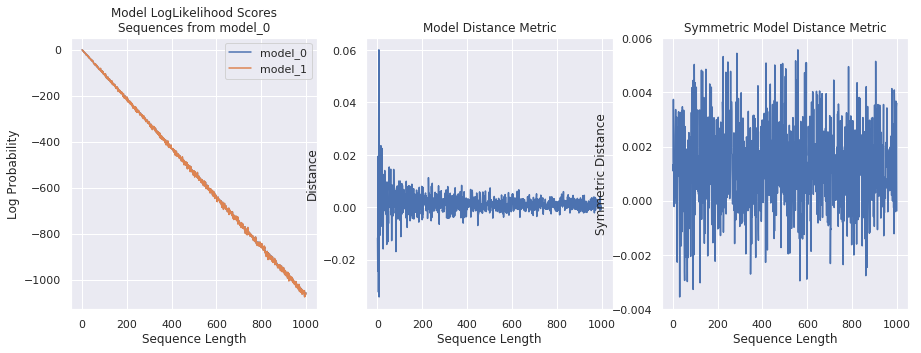

In [38]:
_ = distance.run_model_distance_tests(
    classifier_mle.estimators["class-b"], 
    original.estimators["class-b"]
)


### Next steps

#### HMM Library 'Chapter'

Goal is to build a full featured modern library for HMMs based on the well established API provided by scikit-learn.

    1. [Done] Directly compute HMM parameters from "observed" hidden states. Usefull for testing.
    2. [In Progress] Techniques for selecting the best model for data
    3. [In Progress] Expand to HMMS for Continuous Data
         a. [DONE] Univariate Gaussian
         b. [TODO] Multivariate Gaussian
         c. [TODO] Gaussian Mixture Model
         d. [TODO] Other Distributions
    4. [Reading] Techniques and decisions for initializations
         a. Gaussian - Use Kmeans, but what about variance
         b. Multinomial - initialize B randomly, A and Pi to 1/number of states
         c. others - TODO
    5. [Reading] Other training methods of HMM (Variational Bayes, MCMC)
    6. [Reading] HMM Parameter estimation
    7. [Reading] Discriminate Training for Classification
         a. Train an HMM on each class, but optimize both jointly on the predictions made by the join model. Requires changes to training.
         b. popular in the 90s for Speech Recognition systems, largely supplanted by deep-learning RNNS it seems
         c. One method involves a form of gradient descent
         d. Need to revist some Maths...
         e. https://wiki.eecs.yorku.ca/course_archive/2011-12/W/6328/_media/jiang_dt_survey.pdf
         f. https://pdfs.semanticscholar.org/cdb2/48a314771e6e53e278b5554afe90677a1e35.pdf
    8. HMM For longer time dependencies, not just T=1
    9. HMMs still seem to have a home in the era of deep learning, especially where generative models are needed, or where analysis of the latent states, but in the classification setting are largely dismissed.  Some research on using HMMs to model the internal structures of Recurrent Neural Networks and LSTMs.

#### Churn Prediction 'Chapter'
    1. Conform underlying code to new API
    2. [DONE] Port to Python 3
    3. Rip our "exploring hidden states" bits, and use standard Model Selection Techniques
    4. More informed model selection
   